# Import Packages

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import set_config
set_config(display='diagram')



# Reloading in the Data

In [2]:
df = pd.read_csv('Data/sales_predictions (3).csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Performing Preprocessing Steps

## Data Cleaning Before Data Spliting

In [3]:
# Drop unnecessary columns: these columns don't make impact on the prediction of the sales.

df.drop(columns = ['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'],  axis = 1, inplace = True)

In [4]:
# Drop any duplicates
df.duplicated().sum()

0

In [5]:
# Checking missing values. And display the data information.
print(df.info())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           7060 non-null   float64
 1   Item_Fat_Content      8523 non-null   object 
 2   Item_Visibility       8523 non-null   float64
 3   Item_Type             8523 non-null   object 
 4   Item_MRP              8523 non-null   float64
 5   Outlet_Size           6113 non-null   object 
 6   Outlet_Location_Type  8523 non-null   object 
 7   Outlet_Type           8523 non-null   object 
 8   Item_Outlet_Sales     8523 non-null   float64
dtypes: float64(4), object(5)
memory usage: 599.4+ KB
None


Item_Weight             1463
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64

In [6]:
# the stats informaiton of the data.
df.describe(include='all')

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,7060.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,NaN,5,NaN,16,NaN,3,3,4,NaN
top,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,NaN,5089,NaN,1232,NaN,2793,3350,5577,NaN
mean,12.857645,NaN,0.066132,NaN,140.992782,NaN,NaN,NaN,2181.288914
std,4.643456,NaN,0.051598,NaN,62.275067,NaN,NaN,NaN,1706.499616
min,4.555000,NaN,0.000000,NaN,31.290000,NaN,NaN,NaN,33.290000
25%,8.773750,NaN,0.026989,NaN,93.826500,NaN,NaN,NaN,834.247400
50%,12.600000,NaN,0.053931,NaN,143.012800,NaN,NaN,NaN,1794.331000
75%,16.850000,NaN,0.094585,NaN,185.643700,NaN,NaN,NaN,3101.296400


In [7]:
# fix any inconsistent categories of data
# filter out all the object dtype columns
dtypes = df.dtypes
cat_cols = dtypes[dtypes=="object"].index
for col in cat_cols:
  print(f'-Column={col}')
  print(df[col].value_counts(dropna=False))
  print('\n\n')

-Column=Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



-Column=Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



-Column=Outlet_Size
Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64



-Column=Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64



-Column=Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3  

In [8]:
# address the inconsistence in Item_Fat_Content column.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat',
                                                        'low fat' : 'Low Fat',
                                                        'reg' : 'Regular'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Validation Split

In [9]:
# Split X and y.
X = df.drop(columns= 'Item_Outlet_Sales')
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Create a ColumnTransformer for Preprocessing

In [10]:
# Instantiate the transformers
scaler = StandardScaler()
mean_imputer = SimpleImputer(strategy='mean') # this used for dealing with the missing values in item_weight column.
freq_imputer = SimpleImputer(strategy='most_frequent') # this is used for dealing with the missing values in outlet_size column.
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ordinal = OrdinalEncoder()

In [11]:
# Prepare separate processing pipelines for numeric and categorical data
num_pipe = make_pipeline(mean_imputer, scaler)
nom_pipe = make_pipeline(ohe)
ord_pipe = make_pipeline(freq_imputer, ordinal)

In [12]:
# Create ColumnSelectors for the the numeric and categorical data
nominal_cols = ['Item_Type', 'Outlet_Location_Type', 'Outlet_Type']
ordinal_cols = ['Item_Fat_Content', 'Outlet_Size']
num_selector = make_column_selector(dtype_include='number')

In [13]:
# Combine the Pipelines and ColumnSelectors into tuples for the ColumnTransformer
nom_tuple = (nom_pipe, nominal_cols)
ord_tuple = (ord_pipe, ordinal_cols)
num_tuple = (num_pipe, num_selector)

In [14]:
# Create the preprocessing ColumnTransformer
preprocessor = make_column_transformer(nom_tuple, ord_tuple, num_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Type', 'Outlet_Location_Type',
                                  'Outlet_Type']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['Item_Fat_Content', 'Outlet_Size']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6C52AF400>)])

## Check the Result

In [15]:
# fit the column transformer on the training data.
preprocessor.fit(X_train)
# transform both training and testing data.
X_train_transformed = preprocessor.transform(X_train)

X_test_transformed = preprocessor.transform(X_test)

X_train_transformed.shape

(6392, 28)

In [16]:
# convert the training data to dataframe.
X_train_df = pd.DataFrame(X_train_transformed)
X_train_df.head().round(2)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.82,-0.71,1.83
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.56,-1.29,0.60
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,-0.13,1.81,0.24
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-1.17,-1.00,-0.95
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.53,-0.97,-0.34


In [17]:
X_train_df.isna().sum().sum()

0

# Machine Learning: Training the Models


## Function to Evaluate Model

In [21]:
def evaluate_model(y_true, y_pred, split='training'):

  r2 = r2_score(y_true,y_pred)
  mae = mean_absolute_error(y_true,y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true,y_pred,squared=False)

  
  print(f'Results for {split} data:')
  print(f"  - R^2 = {round(r2,3)}")
  print(f"  - MAE = {round(mae,3)}")
  print(f"  - MSE = {round(mse,3)}")
  print(f"  - RMSE = {round(rmse,3)}")
  print()
    

## Fitting Linear Regression Model

In [18]:
# Instantiate a linear regression model
linreg = LinearRegression()
# Combine the preprocessing ColumnTransformer and the linear regression model in a Pipeline
linreg_pipe = make_pipeline(preprocessor, linreg)
linreg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Type',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Item_Fat_Content',
                                                   'Outlet_Size']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6C52AF400>)])),
                ('linearregression', LinearRegression())])

In [19]:
# Fit the model pipeline on the training data
linreg_pipe.fit(X_train, y_train)
# Make predictions using the training and testing data
training_predictions = linreg_pipe.predict(X_train)
test_predictions = linreg_pipe.predict(X_test)

### Evaluating Linear Regression Model

In [23]:
# evaluate model's performance.
evaluate_model(y_train, training_predictions, split='training')
evaluate_model(y_test, test_predictions, split='testing')

Results for training data:
  - R^2 = 0.56
  - MAE = 847.698
  - MSE = 1300680.983
  - RMSE = 1140.474

Results for testing data:
  - R^2 = 0.566
  - MAE = 805.567
  - MSE = 1198348.589
  - RMSE = 1094.691



### Observations of Linear Regression Model

•	According to R2 score, this model performs slightly different on the training set and testing set. Which means there is no overfitting or underfitting. But this model only studies 56% of the data which is not good enough.

•	Both the training set and testing set have high RMSE score.

•	Most likely, this data is not well suited for a Linear Model.

•	Therefor, we will explore using other model to see if we can increase the R2 score and decrease the RMSE score.

## Fitting Decision Tree Regressor Model

In [26]:
# Instantiate a Decision Tree Regressor model
dec_tree = DecisionTreeRegressor(random_state = 42)
# Combine the preprocessing ColumnTransformer and the decision tree regressor model in a Pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
dec_tree_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Type',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Item_Fat_Content',
                                                   'Outlet_Size']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6C52AF400>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [27]:
# Fit the model pipeline on the training data
dec_tree_pipe.fit(X_train, y_train)
# Make predictions using the training and testing data
training_predictions = dec_tree_pipe.predict(X_train)
test_predictions = dec_tree_pipe.predict(X_test)

### Evaluating Decision Tree Regressor Model

In [28]:
# evaluate model's performance.
evaluate_model(y_train, training_predictions, split='training')
evaluate_model(y_test, test_predictions, split='testing')

Results for training data:
  - R^2 = 1.0
  - MAE = 0.0
  - MSE = 0.0
  - RMSE = 0.0

Results for testing data:
  - R^2 = 0.115
  - MAE = 1077.609
  - MSE = 2441050.699
  - RMSE = 1562.386



### Observations of Decision Tree Regressor Model

•	This model performs extremely well on the training set, but it performs very poorly on the testing set.

•	This model is definitely overfit and will need tuning.


## Tuned Decision Tree Model

### Creating a Loop to Tune Depth for Decision Tree Regressor Model

In [29]:
#create a range of max_depth values
depths = range(1, dec_tree_pipe['decisiontreeregressor'].get_depth())

#create a dataframe to store train and test scores.
scores = pd.DataFrame(columns=['Train', 'Test'], index=depths)

#loop over the values in depths
for n in depths:
  #fit a new model with max_depth
  tree = DecisionTreeRegressor(random_state = 42, max_depth=n)

  #put the model into a pipeline
  tree_pipe = make_pipeline(preprocessor, tree)
  
  #fit the model
  tree_pipe.fit(X_train, y_train)
  
  #create prediction arrays
  train_pred = tree_pipe.predict(X_train)
  test_pred = tree_pipe.predict(X_test)
  
  #evaluate the model using R2 Score
  train_r2score = r2_score(y_train, train_pred)
  test_r2score = r2_score(y_test, test_pred)
  
  #store the scores in the scores dataframe
  scores.loc[n, 'Train'] = train_r2score
  scores.loc[n, 'Test'] = test_r2score

In [31]:
# print out the scores.
scores.head()

,Train,Test
1,0.237797,0.229683
2,0.431641,0.433778
3,0.524218,0.524222
4,0.582625,0.584005
5,0.60394,0.59471


### Plotting Scores for Decision Tree Train & Test Visually

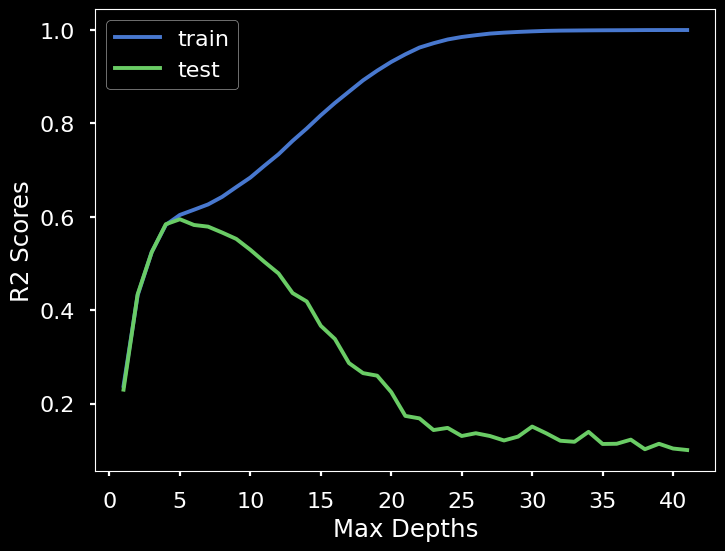

In [36]:
#plot the scores to visually determine the best max_depth
plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])
plt.figure(figsize=(8,6))
plt.plot(depths, scores['Train'], label = 'train')
plt.plot(depths, scores['Test'], label = 'test')
plt.ylabel('R2 Scores')
plt.xlabel('Max Depths')
plt.legend()
plt.show()

In [37]:
#sort the dataframe by test scores and save the index (k) of the best score
best_depth = scores.sort_values(by='Test', ascending=False).index[0]
best_depth

5

### Fitting the tuned Decision Tree Model

In [39]:
# Instantiate a Decision Tree Regressor model
tuned_dec_tree = DecisionTreeRegressor(random_state = 42, max_depth=best_depth)
# Combine the preprocessing ColumnTransformer and the decision tree regressor model in a Pipeline
tuned_dec_tree_pipe = make_pipeline(preprocessor, tuned_dec_tree)

# Fit the model pipeline on the training data
tuned_dec_tree_pipe.fit(X_train, y_train)
# Make predictions using the training and testing data
training_predictions = tuned_dec_tree_pipe.predict(X_train)
test_predictions = tuned_dec_tree_pipe.predict(X_test)

### Evaluating Tuned Decision Tree Model

In [40]:
# evaluate model's performance.
evaluate_model(y_train, training_predictions, split='training')
evaluate_model(y_test, test_predictions, split='testing')

Results for training data:
  - R^2 = 0.604
  - MAE = 762.61
  - MSE = 1172122.773
  - RMSE = 1082.646

Results for testing data:
  - R^2 = 0.595
  - MAE = 738.317
  - MSE = 1118185.973
  - RMSE = 1057.443



### Observations of Tuned Decision Tree  Model

•	Tuning the max depth on the decision tree model improved the results for the testing data.

•	we can see that the tuned model performs poorly on the training set compared to the untuned model. However, it improves the performance on the test set.

•	However, this model still has high bias even after tuning the max depth.

•	Therefor, we will continue to try more models.

## Fitting Random Forest Regressor Model

In [42]:
# Instantiate a Random Forest Regressor model
rf_tree = RandomForestRegressor(random_state = 42)
# Combine the preprocessing ColumnTransformer and the decision tree regressor model in a Pipeline
rf_tree_pipe = make_pipeline(preprocessor, rf_tree)

# Fit the model pipeline on the training data
rf_tree_pipe.fit(X_train, y_train)
# Make predictions using the training and testing data
training_predictions = rf_tree_pipe.predict(X_train)
test_predictions = rf_tree_pipe.predict(X_test)

### Evaluating Random Forest Regressor Model

In [43]:
# evaluate model's performance.
evaluate_model(y_train, training_predictions, split='training')
evaluate_model(y_test, test_predictions, split='testing')

Results for training data:
  - R^2 = 0.937
  - MAE = 300.247
  - MSE = 187035.28
  - RMSE = 432.476

Results for testing data:
  - R^2 = 0.547
  - MAE = 773.579
  - MSE = 1249404.569
  - RMSE = 1117.768



### Observation of Random Forest Regressor Model

•	This model imporves the training set performance.However, performs poorly on testing set

•	This model still has some bias


•	Therefor, Let's try to tune this model.

## Tuned Random Forest Regressor Model

### Creating a Loop to Tune n_estimators for Random Forest Regressor Model

In [44]:
#create a range of max_depth values
n_estimators = [50, 100, 200, 300, 400, 500, 600, 700, 800, 1000, 2000, 3000, 4000, 5000]

#create a dataframe to store train and test scores.
scores = pd.DataFrame(columns=['Train', 'Test'], index=n_estimators)

#loop over the values in depths
for n in n_estimators:
  #fit a new model with max_depth
  rf = RandomForestRegressor(random_state = 42, n_estimators=n)

  #put the model into a pipeline
  rf_pipe = make_pipeline(preprocessor, rf)
  
  #fit the model
  rf_pipe.fit(X_train, y_train)
  
  #create prediction arrays
  train_pred = rf_pipe.predict(X_train)
  test_pred = rf_pipe.predict(X_test)
  
  #evaluate the model using R2 Score
  train_r2score = r2_score(y_train, train_pred)
  test_r2score = r2_score(y_test, test_pred)
  
  #store the scores in the scores dataframe
  scores.loc[n, 'Train'] = train_r2score
  scores.loc[n, 'Test'] = test_r2score

In [45]:
best_estimators = scores.sort_values(by='Test', ascending=False).index[0]
best_estimators

200

### Fitting Tuned Random Forest Regressor Model

In [46]:
# Instantiate a Random Forest Regressor model
tuned_rf_tree = RandomForestRegressor(random_state = 42, n_estimators=best_estimators)
# Combine the preprocessing ColumnTransformer and the decision tree regressor model in a Pipeline
tuned_rf_tree_pipe = make_pipeline(preprocessor, tuned_rf_tree)

# Fit the model pipeline on the training data
tuned_rf_tree_pipe.fit(X_train, y_train)
# Make predictions using the training and testing data
training_predictions = tuned_rf_tree_pipe.predict(X_train)
test_predictions = tuned_rf_tree_pipe.predict(X_test)

### Evaluating Tuned Random Forest Regressor Model

In [47]:
# evaluate model's performance.
evaluate_model(y_train, training_predictions, split='training')
evaluate_model(y_test, test_predictions, split='testing')

Results for training data:
  - R^2 = 0.938
  - MAE = 298.272
  - MSE = 182706.053
  - RMSE = 427.441

Results for testing data:
  - R^2 = 0.547
  - MAE = 775.755
  - MSE = 1249085.757
  - RMSE = 1117.625



### Observation of Tuned Random Forest Regressor Model

•	The tuned model barely improve the performance on the testing set.

•	For the R^2 score 54.7% of the variance is explained.


•	For the MAE the testing score is off by about $775.7.

## Best model

Overall, we can see that the best model is Decision Tree Model with the highest R2 score and the lowest RMSE score.